# 2. Feature selection
##### W tej części analizy postaram się wybrać zmienne, które zawierają najwięcej informacji wartościowych na potrzeby naszego modelu. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Zaczniemy od sprawdzenia jak wygląda macierz kolelacji wszystkich naszych zmiennych.

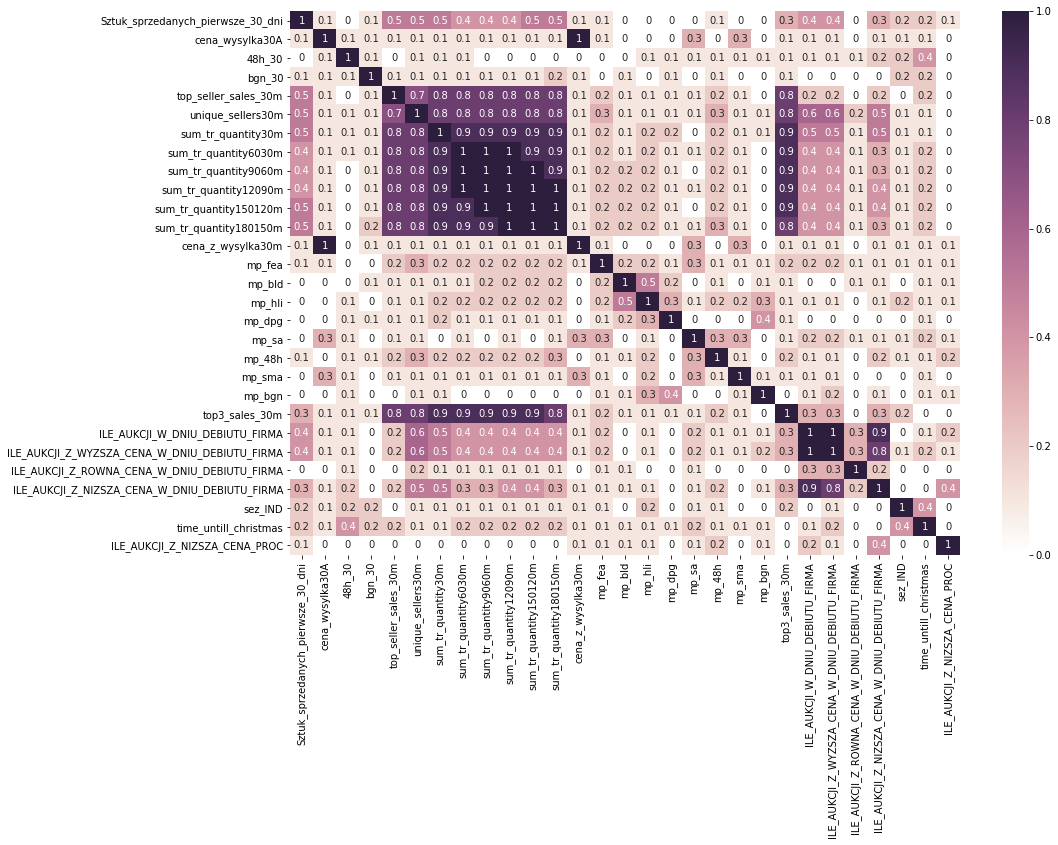

In [2]:
df = pd.read_pickle('data/data_after_cleaning.pkl')

plt.figure(figsize=(15, 10))
ax = sns.heatmap(np.abs(df
                        .corr()
                        .round(decimals=1)),
                 cmap=sns.cubehelix_palette(light=1, as_cmap=True),
                 annot=True)

Od razu można zauważyć, że parę zmiennych jest tożsamych - ich korelacja wynosi równo 1. Istnieje też kilka zmiennych, których korelacja wynosi >0.9. Pozbędziemy się tych bardzo mocno skorelowanych duplikatów.

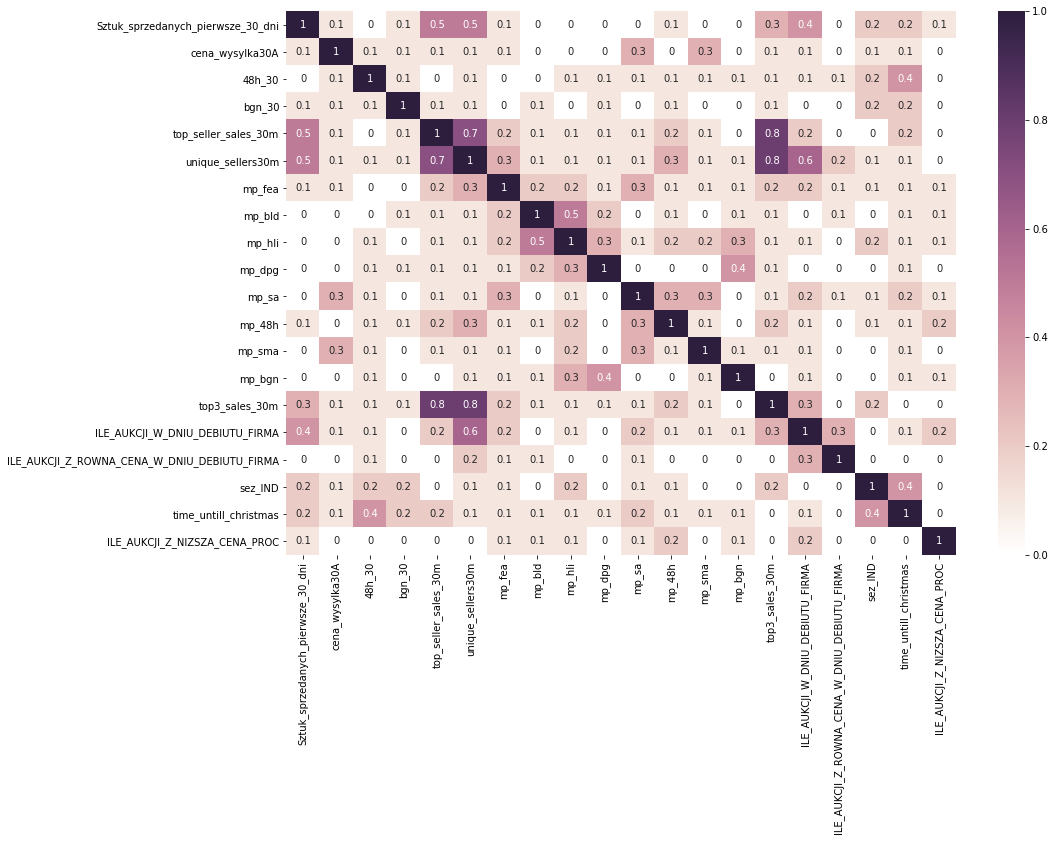

In [3]:
df.drop([
    'cena_z_wysylka30m',
    'ILE_AUKCJI_Z_WYZSZA_CENA_W_DNIU_DEBIUTU_FIRMA',
    'sum_tr_quantity6030m',
    'sum_tr_quantity9060m',
    'sum_tr_quantity12090m',
    'sum_tr_quantity150120m',
    'sum_tr_quantity180150m',
    'ILE_AUKCJI_Z_NIZSZA_CENA_W_DNIU_DEBIUTU_FIRMA',
    'sum_tr_quantity30m'],
    axis=1, inplace=True)

plt.figure(figsize=(15, 10))
ax = sns.heatmap(np.abs(df
                        .corr()
                        .round(decimals=1)),
                 cmap=sns.cubehelix_palette(light=1, as_cmap=True),
                 annot=True)

Następnie sprawdzimy boxploty wszystkich pozostałych zmiennych.

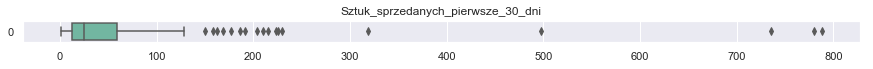

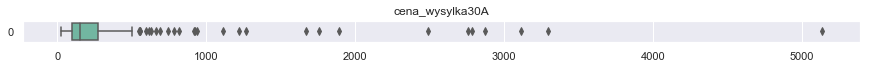

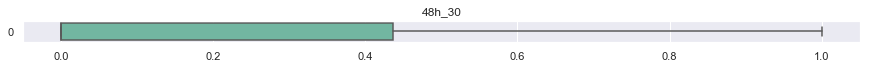

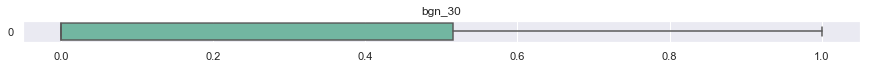

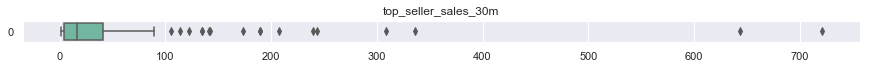

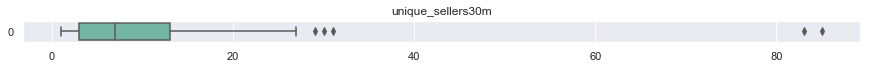

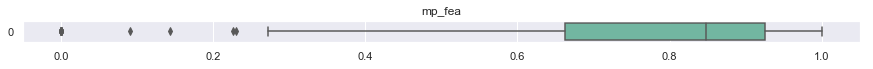

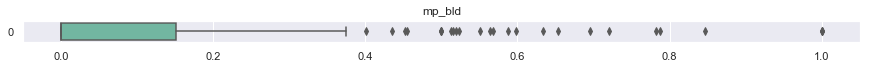

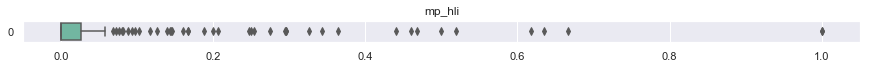

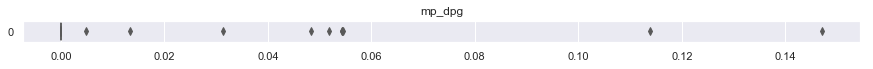

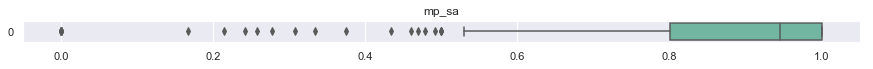

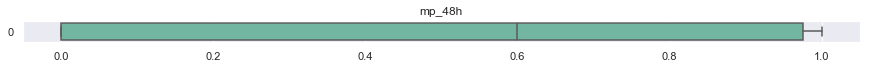

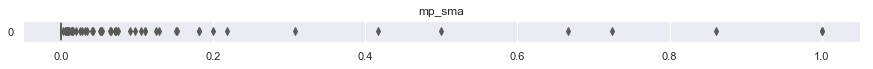

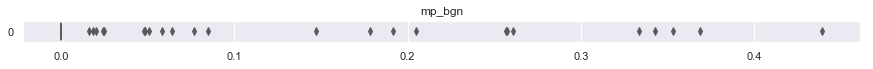

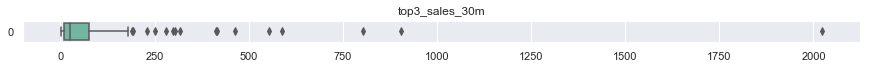

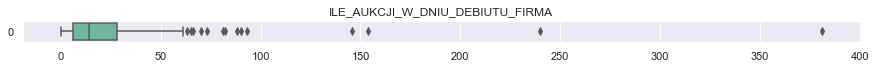

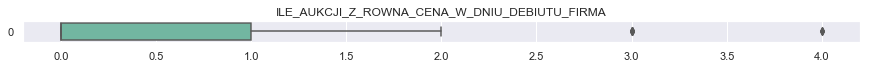

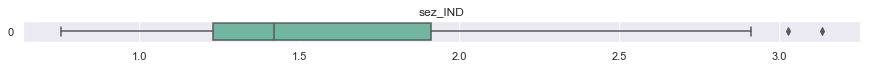

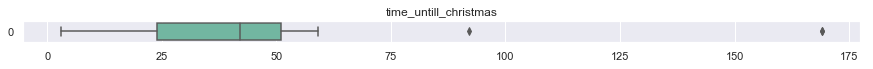

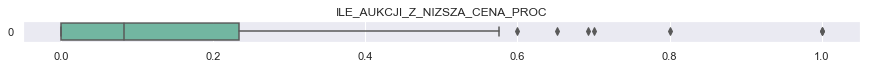

In [5]:
sns.set(rc={'figure.figsize':(15,0.4)})
for feature in df.columns:
    ax = sns.boxplot(data=df[feature], orient="h", palette="Set2")
    ax.set_title(feature)
    plt.show()
    
sns.set(rc={'figure.figsize':(8,8)})

In [6]:
# Zapisz tabele po przekształceniach jako pkl
df.to_pickle('data/data_after_feature_selection.pkl')